# Assignment 7
#### *Find a simple dataset with a one-humped histogram and model it by matching with the pdfs we learned till today.*
#### *Find the most likely parameters for your pdf using MOM. Use the model to do a prediction.*
*Please find an original dataset. Don't use a boring dataset that everyone can easily google for :-)*

I found a dataset about [wine reviews on kaggle](https://www.kaggle.com/datasets/zynicide/wine-reviews). It includes 15000 data that contains wines from all around the wrold.
In this dataset, I'm curious if a pricier wine would have a higher points(grades for satisfaction), and how strong the correlations are.

First thing first, import the libraries used and read the csv file. 

If we look into the file, we would find some price fields empty. An empty field will not be consider under our computation; and because we have a tons of entries, I decide to just drop the empty cells with function `.dropna()` when reading. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [ ]:
df = pd.read_csv("wine_data.csv",index_col=[0]).dropna(subset=['price'])
df.head(100)

Next, in order to clean up the data, I want to excute the outliers. For example, we have some carzy expensive wines that cost 1500 dollar, or some 3 dollar wines(perhaps from trader joes?) I know these wine exist, but I probably can't afford a 1500 dollar wine, and I probably don't have any judgements for those 3 dollar wine. 

So I exclude the data from lower 1% and higher 1%. We can see some data were droped from the ouput below.

In [ ]:
Q99 = int(df["price"].quantile(0.99))
Q01 = int(df["price"].quantile(0.01))
Q99, Q01

In [ ]:
df = df[df['price'] <= Q99]
df = df[df['price'] >= Q01]
df.head(100)

And then we can investigate the data a little bit.

We can observe that:
1. This is a one-humped histogram in terms of points. 
2. All of the points are falling within 80 to 100. I will shift this range to 1 to 20 for readibility and personal preferance. 
3. The prices are heavily left skewed. In other words, there are a lot more cheep wine of under 50 USD comparing to wine that's over 50 USD. I will need to do a normalization for this.  

In [ ]:
df.hist()

I devide the data with interval of 5 in price, and then normalize each column to add up to 100(building probability distributions). Also rename the columns for readibility and fill in empty cells into 0 to avoid computational error.

Each cell here means the frequency of the points of correlating row. 

In [ ]:
#group by intervals
df['price_interval'] = pd.cut(df['price'], bins=np.arange(5*(Q01//5), 5*(Q99//5)+5, 5), right=False)

temp = pd.crosstab(index=df['points'], columns=df['price_interval'])
temp.columns = ["range"+str(int(b))+"_"+str(int(b)+5) for b in range(5*(Q01//5),5*(Q99//5),5)]

#normalization
df = temp.apply(lambda x: (x / x.sum()) * 100, axis=0)
df = df.fillna(0).astype(int)

print(df)

In [ ]:
# _ = df.hist(sharex=True, sharey=True, grid=False)
# plt.tight_layout()

Here I weight the data frame. Because the cells in my df means the frequency of it's points, I need to trace it back to the original point in order to get the correct mean and variance. 

If I use the count df, every column will sum up to 100 because I normalized it in the previous step.

I then use the formula we learned in class to calculate the alpha and beta value, to preform MoM later. 

In [ ]:
df_weight = df.multiply((df.index - 80), axis=0)
print(df_weight)

In [ ]:
mean = df_weight.sum()/100
# mean

In [ ]:
variance = df.var()
# variance

In [ ]:
alpha_mom = (mean**2)/variance
beta_mom = variance/mean
# alpha_mom, beta_mom

Now all of the variables are ready, I want to plot every interval to see how it works.

I list of values for each interval, fill in the desired values to create a figure with subplots, and then create histogram and plot the gamma distribution for current range. Also fix the x and y range with an `exec`.

Finaly, set the title and annotate alpha and beta for each plot. 

In [ ]:
setsize="""
axs[0, 0].set_xlim(0, 20)
axs[0, 0].set_ylim(0, 0.5)
"""

In [ ]:
range_values= [i for i in range(5*(Q01//5),5*(Q99//5),5)] 
fig, axs = plt.subplots(6, 5, figsize=(10, 10), sharex=True, sharey=True)


for i, rangeX in enumerate(range_values):
    
    row_idx = i // 5
    col_idx = i % 5

    axs[row_idx, col_idx].hist(df[f'range{rangeX}_{rangeX+5}'], density=True, bins=7)
    axs[row_idx, col_idx].plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[i], 1/beta_mom[i]))
    if row_idx==0 and col_idx==0: exec(setsize)

    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[i], beta_mom[i])
    axs[row_idx, col_idx].annotate(label, xy=(8, 0.3))
    axs[row_idx, col_idx].set_title(f'range{rangeX}to{rangeX+5}')

plt.tight_layout()
plt.show()

Now I have a good model from historical data, to predict the satisfaction rate from the price of my wine. 

Here's a function that takes the `price` of a bottle of wine as input, and shows you the distribution of satisfaction from previous data. 

In [ ]:
def prediction(price):
    # process int to 5
    price = 5*(price//5)
    x_values = np.linspace(0, 10)
#     pdf_values = gamma.pdf(x_values, a=alpha_mom[f'range{price}_{price+5}'], scale=1/beta_mom[f'range{price}_{price+5}'])
    pdf_values = gamma.pdf(x_values,alpha_mom[f'range{price}_{price+5}'], 1/beta_mom[f'range{price}_{price+5}'])
    plt.plot(x_values, pdf_values, label=f'{price} Predicted Satisfaction Grade', color='orange')

    # Add labels and title
    plt.xlabel('Grade (scale of 10)')
    plt.ylabel('Probability Density')
    plt.title(f'Predicted Satisfaction Grade Distribution for {price}')

    plt.show()

In [ ]:
prediction(37)

### Final Thoughts and Future Work

I also tried to fit our dataset into some pre-train models. Here's a way to utilze it in pymc packages.(Clear the Kernal and run it again if it's giving "matrix contains zeros on the diagonal" error. )

We could see that it doesn't fit into any existing linear regression model. 

There are two potential reasons:
1. Data collecton problem. A dataset that fits into a gamma distribution isn't necessary a linear regression, and because the data are significantly more for under 50 dollar, it might effect the model fitting process. 
2. The regression to fit a model requires a difference of 0.8, my data has a 0.9, meaning points are too concentrate and can't generlized a pattern. 
3. OS subprocess problems. This error code usually occurs in the context of using NLP libraries and frameworks, and it means that I'm are trying to perform an operation that requires an NLP model but my system couldn't load one.

After all, I am predicting the satisfaction solely based on price; however, there are many other factors in real life and it is pretty hard to accuratly predict the satisfaction level of a product based on price. 

/Users/yuujadz/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 125 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yuujadz/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/16/2q3nw0ps4mz9nky281dlnzpm0000gn/T/ipykernel_40994/3662265140.py:24: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/yuujadz/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_py

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

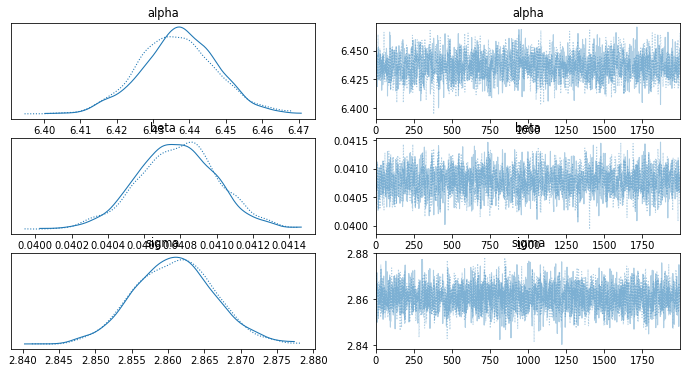

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd

df_new = pd.read_csv("wine_data.csv").dropna(subset=['price'])
x = df_new['price'].values
y = df_new['points'].values-80

# Model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10, testval=0.0)
    beta = pm.Normal('beta', mu=0, sigma=10, testval=0.0)
    
    sigma = pm.HalfNormal('sigma', sigma=1, testval=1.0)
    
    mu = alpha + beta * x
    
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

with model:
    trace = pm.sample(2000, tune=3000, cores=2, init='auto')

pm.summary(trace)
pm.traceplot(trace)
